# <center> Исследование данных HR-агенства.

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

HR-агенство хочет ответить на ***следующие ключевые вопросы***:


- Какие факторы влияют на зарплату у специалистов Data Scientist?
- Наблюдается ли рост зарплат у специалистов Data Scientist за каждый год?
- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
- Как соотносятся зарплаты Data Scientist и Data Engineer в компаниях различных размеров?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

На каждый вопрос необходимо ответить с уровнем значимости $\alpha=0.05$.

Ответить на эти вопросы нам помогут данные о зарплатах в сфере Data Science за 2020–2022 годы.

Данные содержат следующие столбцы:
-   *work_year* — Год, в котором была выплачена зарплата;
-   *experience_level* — Опыт работы на этой должности в течение года со следующими возможными значениями:
    - *EN* — Entry-level/Junior;
    - *MI* — Mid-level/Intermediate;
    - *SE* — Senior-level/Expert;
    - *EX* — Executive-level/Director;
-   *employment_type* — Тип трудоустройства для этой роли:
    - *PT* — неполный рабочий день;
    - *FT* — полный рабочий день;
    - *CT* — контракт;
    - *FL* — фриланс;
-   *job_title* — Роль, в которой соискатель работал в течение года;
-   *salary* — Общая выплаченная валовая сумма заработной платы;
-   *salary_currency* — Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217;
-   *salary_in_usd* — Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через *fxdata.foorilla.com)*;
-   *employee_residence* - Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166;
-   *remote_ratio* - Общий объём работы, выполняемой удалённо. Возможные значения:
    - *0* — удалённой работы нет (менее 20 %);
    - *50* — частично удалённая работа;
    - *100* — полностью удалённая работа (более 80 %);
-   *company_location* - Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166;
-   *company_size* - Среднее количество людей, работавших в компании в течение года:
    - *S* — менее 50 сотрудников (небольшая компания);
    - *M* — от 50 до 250 сотрудников (средняя компания);
    - *L* — более 250 сотрудников (крупная компания).

Источник датасета: [“Data Science Job Salaries” (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

## 1. Загрузка и обработка данных

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.express as px

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

Загружаем датасет

In [2]:
# загружаем датасет
data = pd.read_csv('data/ds_salaries.csv',index_col='Unnamed: 0')
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [3]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


В датасете 607 записей (без пропущенных значений).

Формат данных соответстует информации в датасете.

Проверим данные на наличие полных дубликатов:

In [5]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 42
Размер таблицы после удаления дубликатов: (565, 11)


В датасете имеются неинформативные признаки, такие как *salary* и *salary_currency* которые не имеют информационной значимости и подлежат удалению из фрейма.

In [6]:
data.drop(['salary','salary_currency'],axis=1,inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 565 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           565 non-null    int64 
 1   experience_level    565 non-null    object
 2   employment_type     565 non-null    object
 3   job_title           565 non-null    object
 4   salary_in_usd       565 non-null    int64 
 5   employee_residence  565 non-null    object
 6   remote_ratio        565 non-null    int64 
 7   company_location    565 non-null    object
 8   company_size        565 non-null    object
dtypes: int64(3), object(6)
memory usage: 44.1+ KB


Определим число уникальных категорий в каждом столбце датафрейма

In [7]:
unique_list = []
# пробежим по имени стобцов в таблице
for col in data.columns:
    # создадим кортеж(имя стобца, число уникальных значений)
    item = (col,data[col].nunique(),data[col].dtype)
    # добавляем кортеж в список
    unique_list.append(item)
#создаем вспомогательную таблицу и сортируем ее
unique_count = pd.DataFrame(
    unique_list, 
    columns=['Column_name','Num_Unique','Tupe']
).sort_values(by='Num_Unique',ignore_index=True)
unique_count

,Column_name,Num_Unique,Tupe
0,work_year,3,int64
1,remote_ratio,3,int64
2,company_size,3,object
3,experience_level,4,object
4,employment_type,4,object
5,job_title,50,object
6,company_location,50,object
7,employee_residence,57,object
8,salary_in_usd,369,int64


Для оптимизации работы сделаем преобразование столбцов к типу *category*

In [8]:
#список столбцов, который не берется во внимание
cols_to_exclude = ['work_year']
#задаем максимальное число ункальных категорий
max_unique_count = 5
for col in data.columns:
    if data[col].nunique() < max_unique_count and col not in cols_to_exclude: #проверяем условие
        data[col] = data[col].astype('category') #преобразуем тип

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 565 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   work_year           565 non-null    int64   
 1   experience_level    565 non-null    category
 2   employment_type     565 non-null    category
 3   job_title           565 non-null    object  
 4   salary_in_usd       565 non-null    int64   
 5   employee_residence  565 non-null    object  
 6   remote_ratio        565 non-null    category
 7   company_location    565 non-null    object  
 8   company_size        565 non-null    category
dtypes: category(4), int64(2), object(3)
memory usage: 29.3+ KB


Изучим статистические характеристики для признаков.

In [9]:
data['salary_in_usd'].describe()

count       565.000000
mean     110610.343363
std       72280.702792
min        2859.000000
25%       60757.000000
50%      100000.000000
75%      150000.000000
max      600000.000000
Name: salary_in_usd, dtype: float64

Признак 'salary_in_usd' (Зарплата в долларах США) имеет большой разброс значение (от 2859 до 60000), различный показатели среднего и медианного уровней, что может свидетельствовать о наличии выбосов и отличии распредедления от нормального.

In [10]:
data.describe(include=['category','object'])

,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
count,565,565,565,565,565,565,565
unique,4,4,50,57,3,50,3
top,SE,FT,Data Scientist,US,100,US,M
freq,243,546,130,295,346,318,290


При просмотре описательной статистики категориальных признаков можно отметить, что в признаке *experience_level* (Опыт работы) наиболее востребованным является уровень *Senior-level/Expert* (43% от бощего числа значений), а по признаку *employment_type* (Тип трудоустройства) наибольшее (подавляющее) предпочтение отдается полному рабочему дню (96,6% значений); В названиях профессий наиболее часто встечается професси *Data Scientist* (23%). В данных представлены значения зарплат сотрудников из 57 стран, наиболее популярной из которых является США (52% значенией), а наибольшей популярностью пользуется полностью удалённая работа (61% значений). Страны главного офиса работодателя или филиала по контракту представлены 50 странами, наибольшее количесвто из которых находится в США (56% значений), а большинство компаний являются средними по числу сотрудников (51% значений)

## 2. Разведывательный анализ данных

### 2.1 Визуальный анализ данных

#### Распределение уровня зарплат по всем значениям

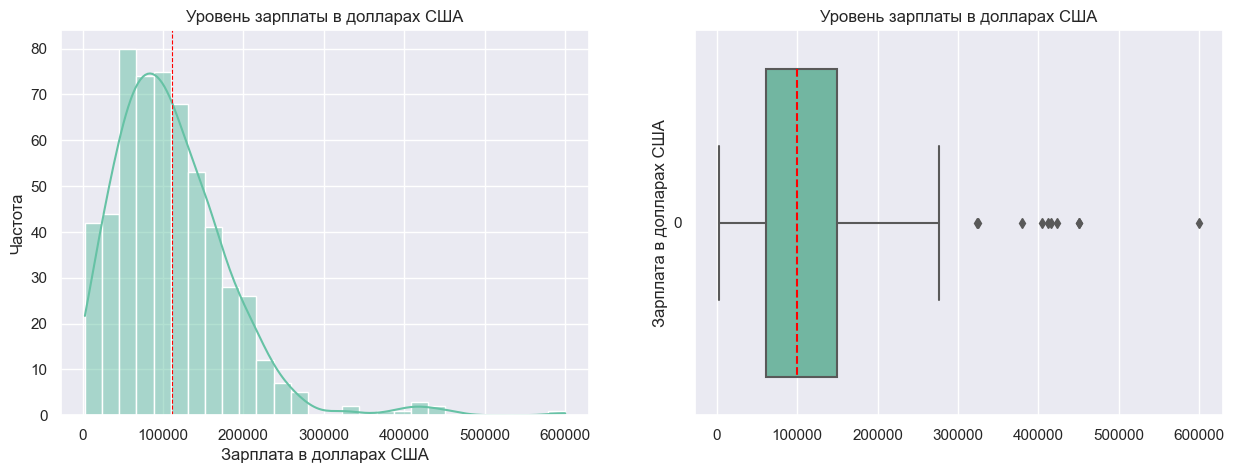

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Зарплата в долларах США', ylabel='Частота')
axes[0].set_title('Уровень зарплаты в долларах США')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Зарплата в долларах США')
axes[1].set_title('Уровень зарплаты в долларах США')

plt.show()

In [45]:
data_agg = data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Размер зарпаты в USD']
data_agg

,Размер зарпаты в USD
count,565.00
mean,110610.34
std,72280.70
min,2859.00
25%,60757.00
50%,100000.00
75%,150000.00
max,600000.00


Распределение уровня зарплат отлично от нормального, имеются предпологаемые выбросы.

#### Распределение уровня зарплат в зависимости от года

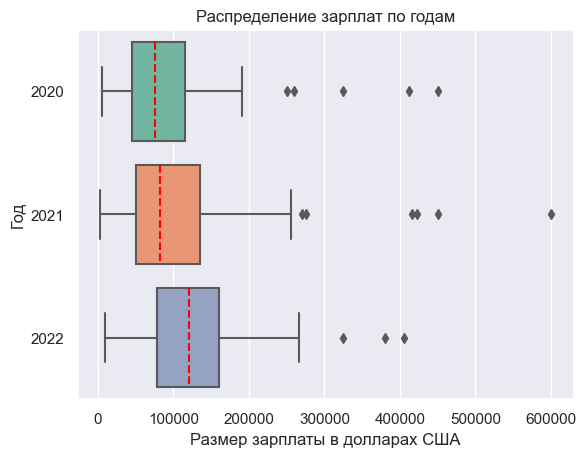

In [13]:
ax = sns.boxplot(data, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплаты в долларах США', ylabel='Год')
plt.title('Распределение зарплат по годам')
plt.show()

In [47]:
data_agg = data.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Уровень зарплаты в зависимости от года')
data_agg

Уровень зарплаты в зависимости от года


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,72.0,95813.00,82831.80,5707.0,45724.5,75544.0,115526.0,450000.0
2021,215.0,99430.41,80304.32,2859.0,50000.0,82528.0,135000.0,600000.0
2022,278.0,123089.10,59888.93,10000.0,78791.0,120000.0,160000.0,405000.0


На первый взгляд распределение уровня зарплат по годам различны. Наблюдаетя заметное увеличние уроня зарплат в 2022 году по сравнению 2020 и 2021. Также видно малое количество записей за 2020 год, что может внести ошибку в статистические исследования. Чтобы определить, являются ли эти различия статистически значимыми, необходимо провести статистическое тестирование.

#### Распределение уровня зарплат в зависимости от опыта работы

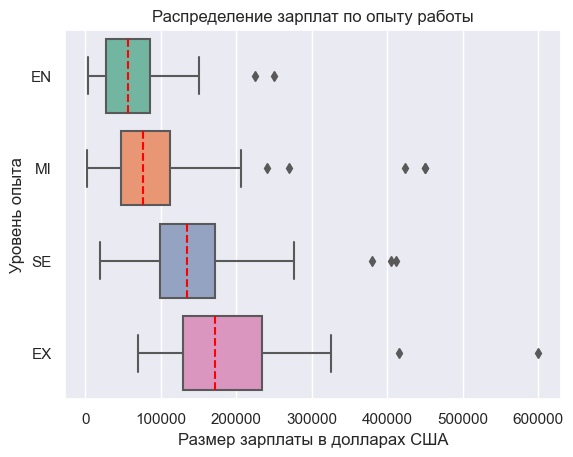

In [15]:
ax = sns.boxplot(data, x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'},order=['EN','MI','SE','EX'])
ax.set(xlabel='Размер зарплаты в долларах США', ylabel='Уровень опыта')

plt.title('Распределение зарплат по опыту работы')
plt.show()


In [48]:
data_agg = data.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Уровень зарплаты в зависимости от опыта работы')
data_agg

Уровень зарплаты в зависимости от опыта работы


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,88.0,61643.32,44395.54,4000.0,27505.00,56500.0,85425.75,250000.0
EX,26.0,199392.04,117071.26,69741.0,130006.50,171437.5,233750.00,600000.0
MI,208.0,87793.00,64118.97,2859.0,47163.75,76940.0,112075.00,450000.0
SE,243.0,138374.88,59955.97,18907.0,99531.50,135000.0,171881.00,412000.0


На первый взгляд распределения уровня зарплат по уровню опыта различны. Ожидаемо наблюдается рост уровня зарплат с увеличением опыта. Чтобы определить, являются ли эти различия статистически значимыми, необходимо провести статистическое тестирование.

#### Распределение уровня зарплат в зависимости от типа трудоустройства

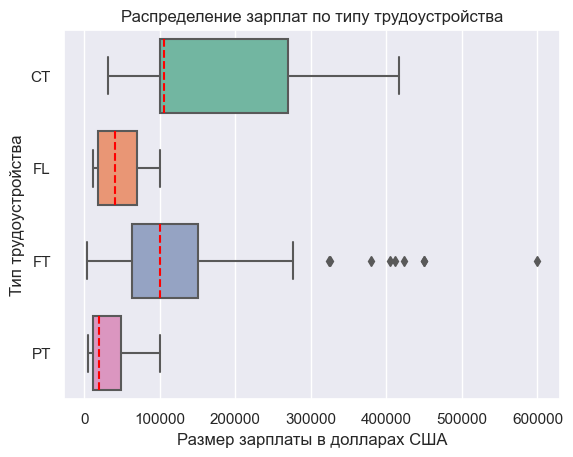

In [17]:
ax = sns.boxplot(data, x='salary_in_usd', y='employment_type', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплаты в долларах США', ylabel='Тип трудоустройства')
plt.title('Распределение зарплат по типу трудоустройства')
plt.show()

In [49]:
data_agg = data.groupby('employment_type')['salary_in_usd'].describe().round(2)
print('Зависимость уровня зарплаты от типа трудоустройства')
data_agg

Зависимость уровня зарплаты от типа трудоустройства


,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
CT,5.0,184575.00,156250.89,31875.0,100000.0,105000.0,270000.0,416000.0
FL,4.0,48000.00,40529.82,12000.0,18000.0,40000.0,70000.0,100000.0
FT,546.0,111811.84,70790.70,2859.0,62726.0,100000.0,150000.0,600000.0
PT,10.0,33070.50,31472.91,5409.0,12000.0,18817.5,48370.0,100000.0


На первый взгляд распределения уровня зарплат по уровню опыта различны. При более детальном рассмотрении можно отметить, что суммарно категории "неполный рабочий день", "фриланс", "контракт" составляют суммарно лишь 19 значение (3.3% от всей выборки) и вряд ли может нести статистическую значимость. Чтобы определить, являются ли эти различия статистически значимыми, необходимо провести статистическое тестирование.

#### Распределение уровня зарплат в зависимости от страны проживания сотрудника

In [19]:
# Записываем URL старницы в Википедии с указанием городов-милионников
url = 'https://ru.wikipedia.org/wiki/ISO_3166-1'
tables = pd.read_html(url) # записываем в переменную HTML-таблицы с указанной страницы
iso_3166 = tables[0]
iso_3166 = iso_3166.drop(['Страна','Цифровой ISO 3166-1','код ISO 3166-2'],axis=1)
iso_3166

data_iso = data.copy()

# заменям двухбуквенный код страны трехбуквенным
data_iso = data_iso.merge(
    iso_3166,
    how='left',
    left_on='employee_residence',
    right_on='Alpha-2 ISO 3166-1'
)
data_iso.rename(columns={'Alpha-3 ISO 3166-1':'employee_residence_iso'},inplace=True)
data_iso.drop(['employee_residence','Alpha-2 ISO 3166-1'],axis=1,inplace=True)

grouped = data_iso.groupby('employee_residence_iso',as_index=False)['salary_in_usd'].mean()

#строим график
fig = px.choropleth(
    data_frame=grouped, #DataFrame
    locations='employee_residence_iso', #столбец с локациями
    locationmode = "ISO-3", #режим сопоставления локаций с базой Plotly
    color="salary_in_usd", #от чего зависит цвет
    range_color=[0, 20e4], #диапазон цвета
    title='Распределение среднего уровня зарплат работников в разрезе страны проживания', #заголовок
    width=800, #ширина
    height=500, #высота
    color_continuous_scale='Greens' #палитра цветов
    
)

#отображаем график
fig.show()

In [50]:
data_agg = data.groupby('employee_residence')['salary_in_usd'].describe().round(2).sort_values('mean')
print('Уровень зарплаты в зависимости от страны проживания сотрудников.')
data_agg

Уровень зарплаты в зависимости от страны проживания сотрудников.


,count,mean,std,min,25%,50%,75%,max
employee_residence,,,,,,,,
IR,1.0,4000.00,NaN,4000.0,4000.00,4000.0,4000.00,4000.0
KE,1.0,9272.00,NaN,9272.0,9272.00,9272.0,9272.00,9272.0
UA,1.0,13400.00,NaN,13400.0,13400.00,13400.0,13400.00,13400.0
MD,1.0,18000.00,NaN,18000.0,18000.00,18000.0,18000.00,18000.0
MX,2.0,18185.00,21674.24,2859.0,10522.00,18185.0,25848.00,33511.0
HN,1.0,20000.00,NaN,20000.0,20000.00,20000.0,20000.00,20000.0
TR,3.0,20096.67,7956.76,12103.0,16137.00,20171.0,24093.50,28016.0
CO,1.0,21844.00,NaN,21844.0,21844.00,21844.0,21844.00,21844.0
RS,1.0,25532.00,NaN,25532.0,25532.00,25532.0,25532.00,25532.0


На первый взгляд распределения уровня зарплат по странам проживания работников различны. Выборки многих стран представлени малым количеством работников (<10), что может затруднить процесс определение статистической значимости. Чтобы определить, являются ли эти различия статистически значимыми, необходимо провести статистическое тестирование.

#### Распределение уровня зарплат в зависимости от объема удаленной работы

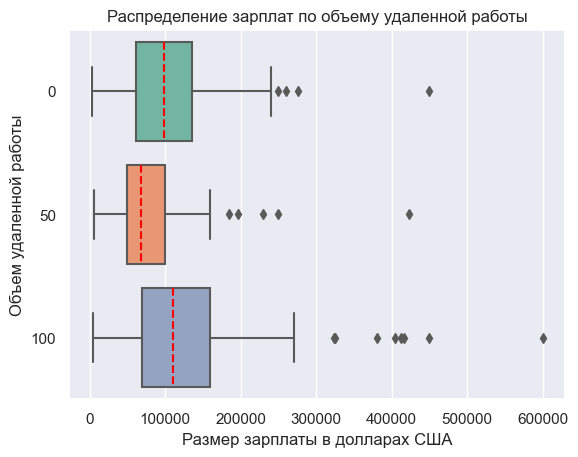

In [21]:
ax = sns.boxplot(data, x='salary_in_usd', y='remote_ratio', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплаты в долларах США', ylabel='Объем удаленной работы')
plt.title('Распределение зарплат по объему удаленной работы')
plt.show()

In [51]:
data_agg = data.groupby('remote_ratio')['salary_in_usd'].describe().round(2).sort_values('mean')
print('Зависимость зарплаты от объема удаленной работы.')
data_agg

Зависимость зарплаты от объема удаленной работы.


,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
50,98.0,80721.90,57639.10,5409.0,50000.5,68010.5,99925.75,423000.0
0,121.0,105785.40,68392.50,2859.0,62000.0,98158.0,136000.00,450000.0
100,346.0,120763.19,74930.43,4000.0,70000.0,110712.5,159750.00,600000.0


На первый взгляд распределения уровня зарплат по объему удаленной работы различны. Можно отметить что подавляющее большинство работников (61% от общего числа) работатют полностью удаленно. А наибольший ровень средней зарплаты отмечается у сотрудников на полностью удаленной работе. Чтобы определить, являются ли эти различия статистически значимыми, необходимо провести статистическое тестирование.

#### Распределение уровня зарплат в зависимости от страны нахожедния офиса или филиала работодателя

In [52]:
# Записываем URL старницы в Википедии с указанием городов-милионников
url = 'https://ru.wikipedia.org/wiki/ISO_3166-1'
tables = pd.read_html(url) # записываем в переменную HTML-таблицы с указанной страницы
iso_3166 = tables[0]
iso_3166 = iso_3166.drop(['Страна','Цифровой ISO 3166-1','код ISO 3166-2'],axis=1)
iso_3166

data_iso = data.copy()

# заменяем двукбуквенный код трехбуквенным
data_iso = data_iso.merge(
    iso_3166,
    how='left',
    left_on='company_location',
    right_on='Alpha-2 ISO 3166-1'
)
data_iso.rename(columns={'Alpha-3 ISO 3166-1':'company_location_iso'},inplace=True)
data_iso.drop(['company_location','Alpha-2 ISO 3166-1'],axis=1,inplace=True)

grouped = data_iso.groupby('company_location_iso',as_index=False)['salary_in_usd'].mean()

#строим график
fig = px.choropleth(
    data_frame=grouped, #DataFrame
    locations='company_location_iso', #столбец с локациями
    locationmode = "ISO-3", #режим сопоставления локаций с базой Plotly
    color="salary_in_usd", #от чего зависит цвет
    range_color=[0, 20e4], #диапазон цвета
    title='Распределение среднего уровня зарплат работников в разрезе страны работодателя', #заголовок
    width=800, #ширина
    height=500, #высота
    color_continuous_scale='Reds' #палитра цветов
    
)

#отображаем график
fig.show()

In [54]:
data_agg = data.groupby('company_location')['salary_in_usd'].describe().round(2).sort_values('mean')
print('Зависимость зарплаты от страны расположения офиса или филиала компании.')
data_agg

Зависимость зарплаты от страны расположения офиса или филиала компании.


,count,mean,std,min,25%,50%,75%,max
company_location,,,,,,,,
VN,1.0,4000.00,NaN,4000.0,4000.00,4000.0,4000.00,4000.0
IR,1.0,4000.00,NaN,4000.0,4000.00,4000.0,4000.00,4000.0
KE,1.0,9272.00,NaN,9272.0,9272.00,9272.0,9272.00,9272.0
PK,3.0,13333.33,6110.10,8000.0,10000.00,12000.0,16000.00,20000.0
UA,1.0,13400.00,NaN,13400.0,13400.00,13400.0,13400.00,13400.0
MD,1.0,18000.00,NaN,18000.0,18000.00,18000.0,18000.00,18000.0
AS,1.0,18053.00,NaN,18053.0,18053.00,18053.0,18053.00,18053.0
BR,3.0,18602.67,5555.76,12901.0,15904.00,18907.0,21453.50,24000.0
HN,1.0,20000.00,NaN,20000.0,20000.00,20000.0,20000.00,20000.0


На первый взгляд распределения уровня зарплат по странам регистрации офиса или филиала работодателя различны. Выборки многих стран представлени малым количеством работников (<10), что может затруднить процесс определение статистической значимости. Чтобы определить, являются ли эти различия статистически значимыми, необходимо провести статистическое тестирование.

#### Распределение уровня зарплат в зависимости от размера компании

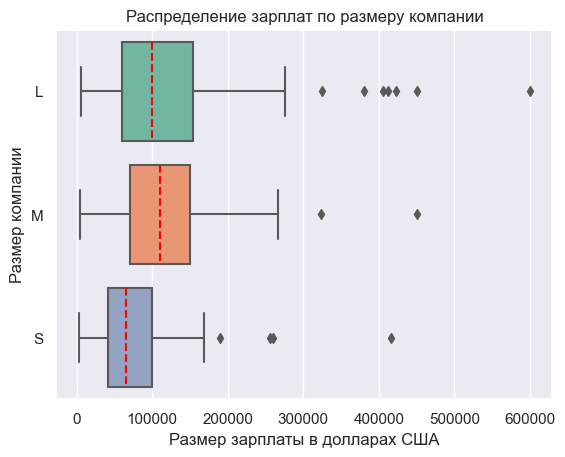

In [25]:
ax = sns.boxplot(data, x='salary_in_usd', y='company_size', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплаты в долларах США', ylabel='Размер компании')
plt.title('Распределение зарплат по размеру компании')
plt.show()

In [55]:
data_agg = data.groupby('company_size')['salary_in_usd'].describe().round(2).sort_values('mean')
print('Зависимость зарплаты от размера компании.')
data_agg

Зависимость зарплаты от размера компании.


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
S,82.0,77872.10,63814.52,2859.0,41816.0,65511.0,100000.00,416000.0
M,290.0,114807.08,60779.04,4000.0,70821.5,109640.0,150213.75,450000.0
L,193.0,118213.88,86753.27,5882.0,60000.0,100000.0,153667.00,600000.0


На первый взгляд распределения уровня зарплат по размеру компании. Наибольший уровень средних зарплат отмечается в компаниях с количеством сотрудников от 50 до 250 человек. Чтобы определить, являются ли эти различия статистически значимыми, необходимо провести статистическое тестирование.

### 2.2. Статистический анализ данных

In [27]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
        
# функция для проверки на равенство диспесий
def decision_dispersion(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
    else:
        print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

#### Наблюдается ли рост зарплат специалистов DataScience за каждый год?

В связи с недостаточным количеством записей за 2020 год мы исключим данный год из статистического анализа.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат специалистов DataScience в 2022 ($μ_1$) статистически меньше либо равен размеру зарплат в 2021 году. ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарплат специалистов DataScience в 2022 ($μ_1$) статистически больше, чем размер зарплат в 2021 году клиентов-женщин ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [28]:
data_datascientist = data[data['job_title']=='Data Scientist']
data_2022 = data_datascientist.loc[ data_datascientist['work_year']==2022, 'salary_in_usd']
data_2021 = data_datascientist.loc[ data_datascientist['work_year']==2021, 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для 2021 года:')
result = stats.shapiro(data_2021)
decision_normality(result[1])

print('Для 2022 года:')
result = stats.shapiro(data_2022)
decision_normality(result[1])


Для 2021 года:
p-value = 0.107
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2022 года:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.

Чтобы проверить нашу гипотезу, можно использовать двухвыборочный t-критерий.

**Проведём тест**

In [29]:
# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(data_2022, data_2021)
decision_dispersion(result[1])

# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p = stats.ttest_ind(data_2022, data_2021, alternative='greater', equal_var=True)
decision_hypothesis(p)


Тест на равенство дисперсий
p-value = 0.264
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.

Тест на равенство средних
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Зарплата специалистов DataScience в 2022 году выросла по сравнению с 2021 годом.

#### Как соотносятся зарплаты специалистов DataScientist и DataEngineer в 2022году?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат специалистов DataScience в 2022 ($μ_1$) не отличаетсся от размера зарплат специалистов DataEngineer. ($μ_2$).

$$ H_0 : μ_1 = μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарплат специалистов DataScience в 2022 ($μ_1$) отличается от размера зарплат специалистов DataEngineer.($μ_2$).

$$ H_1 : μ_1 \neq μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [30]:
data_datascientist = data[data['job_title']=='Data Scientist']
data_dataengineer = data[data['job_title']=='Data Engineer']
data_datascientist_2022 = data_datascientist.loc[ data_datascientist['work_year']==2022, 'salary_in_usd']
data_dataengineer_2022 = data_dataengineer.loc[ data_dataengineer['work_year']==2022, 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для специалистов DataScience:')
result = stats.shapiro(data_datascientist_2022)
decision_normality(result[1])

print('Для специалистов Data Engineer:')
result = stats.shapiro(data_dataengineer_2022)
decision_normality(result[1])


Для специалистов DataScience:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для специалистов Data Engineer:
p-value = 0.007
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни.

**Проведём тест**

In [31]:
# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p = stats.mannwhitneyu(data_datascientist_2022, data_dataengineer_2022)
decision_hypothesis(p)


Тест на равенство средних
p-value = 0.319
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Зарплата специалистов DataScience в 2022 году не отличается от зарплаты специалистов DataEngineer.

#### Как соотносятся зарплаты специалистов DataScientist в компаниях различных размеров?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат специалистов DataScience в небольшой компании ($μ_1$), средней компании ($μ_2$) и крупной компании ($μ_3$) не отличаются.

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза* ($H_1$): размер зарплат специалистов DataScience в небольшой компании ($μ_1$), средней компании ($μ_2$) и крупной компании ($μ_3$) отличаются.

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [32]:
data_datascientist = data[data['job_title']=='Data Scientist']
data_datascientist_comsize_s = data_datascientist.loc[ data_datascientist['company_size']=='S', 'salary_in_usd']
data_datascientist_comsize_m = data_datascientist.loc[ data_datascientist['company_size']=='M', 'salary_in_usd']
data_datascientist_comsize_l = data_datascientist.loc[ data_datascientist['company_size']=='L', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для специалистов DataScience в небольших компаниях:')
result = stats.shapiro(data_datascientist_comsize_s)
decision_normality(result[1])

print('Для специалистов DataScience в средних компаниях:')
result = stats.shapiro(data_datascientist_comsize_m)
decision_normality(result[1])

print('Для специалистов DataScience в крупных компаниях:')
result = stats.shapiro(data_datascientist_comsize_l)
decision_normality(result[1])


Для специалистов DataScience в небольших компаниях:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для специалистов DataScience в средних компаниях:
p-value = 0.897
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для специалистов DataScience в крупных компаниях:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [33]:
# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p = stats.kruskal(data_datascientist_comsize_s, data_datascientist_comsize_m, data_datascientist_comsize_l)
decision_hypothesis(p)


Тест на равенство средних
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Зарплата специалистов DataScience в небольших, средних и крупных компаниях отличается.

#### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: наличие должностей Data Scientist и Data Engineer не взаимосвязаны с размером компании.


*Альтернативная гипотеза* наличие должностей Data Scientist и Data Engineer взаимосвязаны с размером компании.

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер компании»? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [34]:
data_datascientist = data[(data['job_title']=='Data Scientist')|(data['job_title']=='Data Engineer')]

# составляем таблицу сопряжённости
cross_table = pd.crosstab(data_datascientist['job_title'], data_datascientist['company_size'])

cross_table

company_size,L,M,S
job_title,,,
Data Engineer,34,81,6
Data Scientist,43,66,21


In [35]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.005
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Существует статистически значимая взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании.

## Дополнительное исследование.

#### Как соотносятся зарплаты специалистов DataScientist в зависимости от работы?

Ознакомимся с соствавом анализируемых данных

In [36]:
# ознакомимся с составом данных
data_datascientist = data[data['job_title']=='Data Scientist']
data_datascientist.groupby('experience_level')['experience_level'].count()

experience_level
EN    22
EX     0
MI    59
SE    49
Name: experience_level, dtype: int64

Видно, что данных о зарплатах специалистов Data Science с опытом EX — Executive-level/Director нет, а с опытом Entry-level/Junior мало, поэтому исключим их из дальнейшего анализа.



**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат специалистов DataScience в уровней Entry-level/Junior ($μ_1$), Mid-level/Intermediate ($μ_2$), Senior-level/Expert ($μ_3$) и Executive-level/Director ($μ_4$) не отличаются.

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4$$

*Альтернативная гипотеза* ($H_1$): размер зарплат специалистов DataScience в уровней Entry-level/Junior ($μ_1$), Mid-level/Intermediate ($μ_2$), Senior-level/Expert ($μ_3$) и Executive-level/Director ($μ_4$) отличаются.

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [39]:
data_datascientist = data[data['job_title']=='Data Scientist']
data_datascientist_mi = data_datascientist.loc[ data_datascientist['experience_level']=='MI', 'salary_in_usd']
data_datascientist_se = data_datascientist.loc[ data_datascientist['experience_level']=='SE', 'salary_in_usd']



print('Для специалистов DataScience уровня Mid-level/Intermediate:')
result = stats.shapiro(data_datascientist_mi)
decision_normality(result[1])

print('Для специалистов DataScience уровн Senior-level/Expert:')
result = stats.shapiro(data_datascientist_se)
decision_normality(result[1])



Для специалистов DataScience уровня Mid-level/Intermediate:
p-value = 0.146
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для специалистов DataScience уровн Senior-level/Expert:
p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни.

**Проведём тест**

In [40]:
# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p = stats.mannwhitneyu(data_datascientist_mi, data_datascientist_se)
decision_hypothesis(p)


Тест на равенство средних
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Зарплата специалиста Data Science для различных значений опыта работы отличается.

#### Является ли зарплата специалиста Data Science, проживающих в США выше средней зарплаты по всей выборке?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): средний уровень зарплаты специалистов DataScience, проживающих в США($μ$) ниже или равен среднему уровню зарплат по всей выборке(110610 USD).

$$ H_0 : μ_1 \leq 110610$$

*Альтернативная гипотеза* ($H_1$): средний уровень зарплаты специалистов DataScience, проживающих в США($μ$) выше среднего уровня зарплат по всей выборке(110610 USD).

$$ H_0 : μ_1 > 110610$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [41]:
data_datascientist = data[data['job_title']=='Data Engineer']
data_datascientist_us = data_datascientist.loc[ data_datascientist['employee_residence']=='US', 'salary_in_usd']


print('Для специалистов DataScience на полностью удаленной работе:')
result = stats.shapiro(data_datascientist_us)
decision_normality(result[1])


Для специалистов DataScience на полностью удаленной работе:
p-value = 0.160
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Одна.
* Признак распределён по нормальному закону? — Да.

Чтобы проверить нашу гипотезу, можно использовать Критерий знаков (для одной группы).

**Проведём тест**

In [42]:
# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p = stats.ttest_1samp(data_datascientist_us, popmean=110610, alternative='greater')
decision_hypothesis(p)


Тест на равенство средних
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Зарплата специалиста Data Science, проживающих в США выше уровня средней зарплаты по всей выборке.

## Итоговые результаты исследования

1. Какие факторы влияют на зарплату специалиста Data Science:
    - согласно статистических исследований наблюдается ежегодный рост зарплаты, а также наблюдается зависимость от таких параметров, как размер компании, опыта работы, места жительства.
2. Ключевые вопросы HR агенства:
    - наблюдается ли рост зарплат специалистов Data Scienitst зв каждый годд?
        - Зарплата специалистов Data Science в 2022 году выросла по сравнению с 2021 годом.
    - Как соотносятся зарплаты специалистов Data Scientist и DataEngineer в 2022году?
        - Зарплата специалистов Data Science в 2022 году не отличается от зарплаты специалистов DataEngineer.
    - Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
        - Зарплата специалистов Data Science в небольших, средних и крупных компаниях отличается.
    - Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
        - Существует статистически значимая взаимосвязь между наличием должностей Data Scientist и Data Engineer и размером компании.